[TOC]

# Advanced Lane Finding Project

author liangtaohy@gmail.com

## Goals

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Helper Functions

In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

"""The following are helper functions"""

def draw_images(img, undistorted=None, title1="Original Image", title=None, cmap=None, outputfig=None):
    """
    draw images in (1, 2) mode
    """
    if undistorted is not None:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    else:
        f, ax1 = plt.subplots(1,1, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title(title1, fontsize=50)
    if undistorted is not None:
        if cmap is not None:
            ax2.imshow(undistorted, cmap=cmap)
        else:
            ax2.imshow(undistorted)
        ax2.set_title(title, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    if outputfig is not None:
        plt.savefig(outputfig)

## Camera Calibration

A function estimates the intrinsic camera parameters and extrinsic parameters for each of the views. An object with a known geometry and easily detectable feature points is called a calibration rig or calibration pattern. OpenCV has built-in support for a chessboard as a calibration rig.

For more detail, see [camera_calibration](https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html)

In [3]:
def camera_calibration(corners=(9,6), camera_cal_dir='camera_cal'):
    """
    load camera chessboard images and calibrate camera, get mtx and dst parameters for camera calibration
    """
    nx = corners[0]  # corners on x axis
    ny = corners[1]  # corners on y axis

    # prepare object points
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    # termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.

    images = glob.glob(os.path.join(camera_cal_dir, '*.jpg'))
    imgs = []
    for fname in images:
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

        # Find the chess board corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)
        # If found, add object points, image points (after refining them)
        if ret == True:
            objpoints.append(objp)
            #corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (nx,ny), corners,ret)
            imgs.append(img)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return ret, mtx, dist, rvecs, tvecs, imgs

# Camera Calibration
ret, mtx, dist, rvecs, tvecs, imgs = camera_calibration()

### Distortion Correction Example

I use `cameraMatrix` (mtx) and `distortionCoeffs` (dist) to undistort the image.

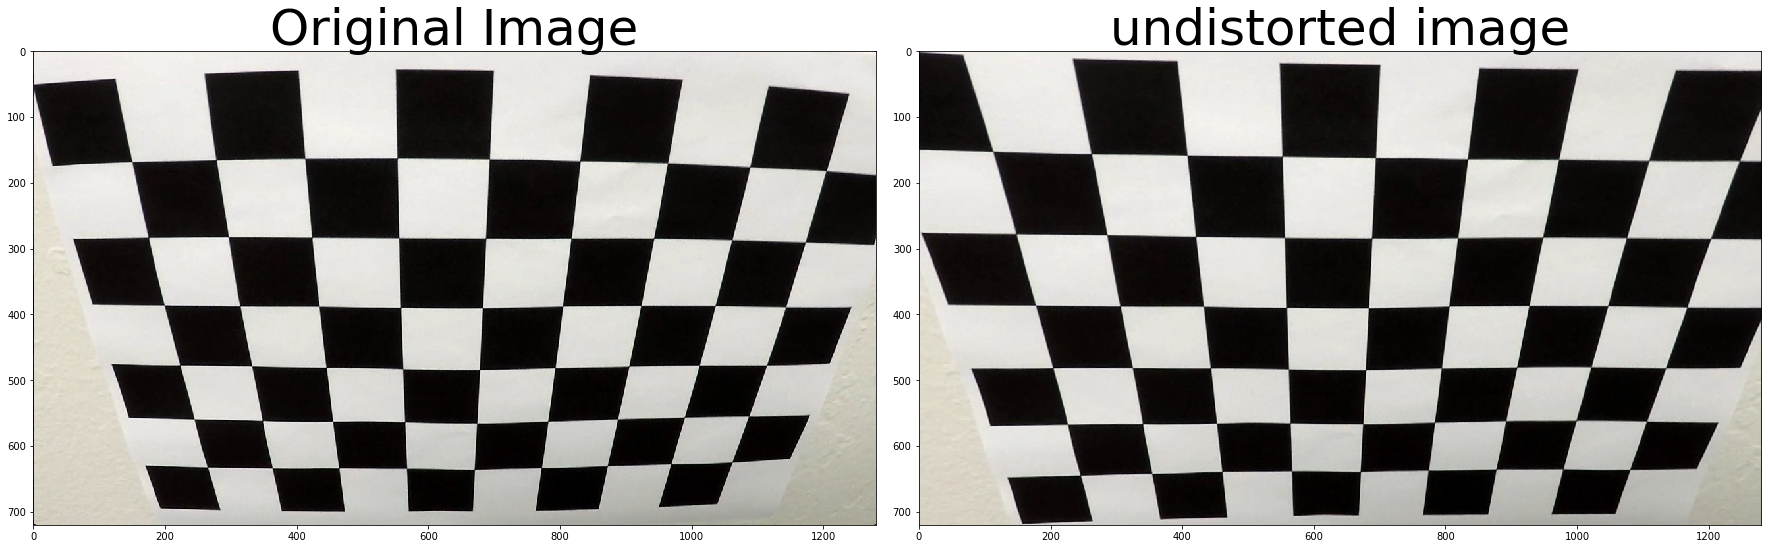

In [4]:
img = mpimg.imread('camera_cal/calibration2.jpg')
undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)
draw_images(img, undistorted_img, title="undistorted image", outputfig='output_images/calibration2.png')

## To create a thresholded binary image

As learned from this lesson, I use color space and gradient to create a binary image.

In [5]:
# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(80,255)):
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the S channel
    # 3) Return a binary image of threshold result
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    binary_output = np.zeros_like(s)
    binary_output[(s>thresh[0]) & (s<=thresh[1])] = 1
    return binary_output

def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(10, 100)):
    thresh_min, thresh_max = thresh[0], thresh[1]
    x = 0
    y = 0
    if orient == 'x':
        x = 1
    else:
        y = 1
    # Apply cv2.Sobel()
    sobel = cv2.Sobel(gray, cv2.CV_64F, x, y, ksize=sobel_kernel)
    # Take the absolute value of the output from cv2.Sobel()
    absolute_sobel = np.absolute(sobel)
    # Scale the result to an 8-bit range (0-255)
    scaled_sobel = np.uint8(255 * absolute_sobel / np.max(absolute_sobel))
    # Apply lower and upper thresholds
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply the following steps to img
    # 1) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 2) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 3) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(abs_sobely, abs_sobelx)
    # 4) Create a binary mask where direction thresholds are met
    direction = np.absolute(direction)
    binary_output = np.zeros_like(direction)
    binary_output[(direction>=thresh[0]) & (direction<=thresh[1])] = 1
    return binary_output

def region_vertices(image):
    """
    Auto compute region vertices with a stable window [(0.1, -2), (0.45, 0.6), (0.6, 0.6), (0.1, -2)]
    """
    width = image.shape[1]
    height = image.shape[0]

    v_top_left = [int(width*0.50), int(height*0.5)]
    v_top_right = [int(width*0.55), int(height*0.5)]
    v_bottom_left = [0, height-1]
    v_bottom_right = [width - 1, height-1]
    return np.array([[v_bottom_left, v_top_left, v_top_right, v_bottom_right]], dtype=np.int32)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    if vertices is None:
        raise ValueError("invalid vertices")

    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def get_thresholded_binary(img):
    # 0) Undistort image
    image = cv2.undistort(img, mtx, dist, None, mtx)
    # 1) Get Grayscale image
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Get sobel on x axis
    sobel_x = abs_sobel_thresh(gray, thresh=(20, 200))
    # 3) Direction Gradient. The threshold is [30, 90].
    d_threshold = dir_threshold(gray, thresh=(np.pi/6, np.pi/2))
    
    combined = ((sobel_x == 1) & (d_threshold == 1))
    
    # 4) RGB selection for the yellow line
    color_thresh = 150
    R = image[:,:,0]
    G = image[:,:,1]
    r_g_threshold = (R > color_thresh) & (G > color_thresh)
    
    # 5) hls select
    s_thresh=(100, 255)
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    L = hls[:,:,1]
    
    s_condition = (S > s_thresh[0]) & (S <= s_thresh[1])
    
    l_thresh = (120, 255)
    l_condition = (L > l_thresh[0]) & (L <= l_thresh[1])
    
    color_combined = np.zeros_like(gray)
    color_combined[(r_g_threshold & l_condition) & (s_condition | combined)] = 1
    
    # 6) Apply ROI select for interested region
    binary_output = region_of_interest(color_combined, region_vertices(gray))
    
    return binary_output

### Thresholded Binary Image Example

Now, I try to combine s channel and sobel x gradient together. The default hls threshhold is `(100,255)`.The default x gradient threshhold is `(10,255)`.

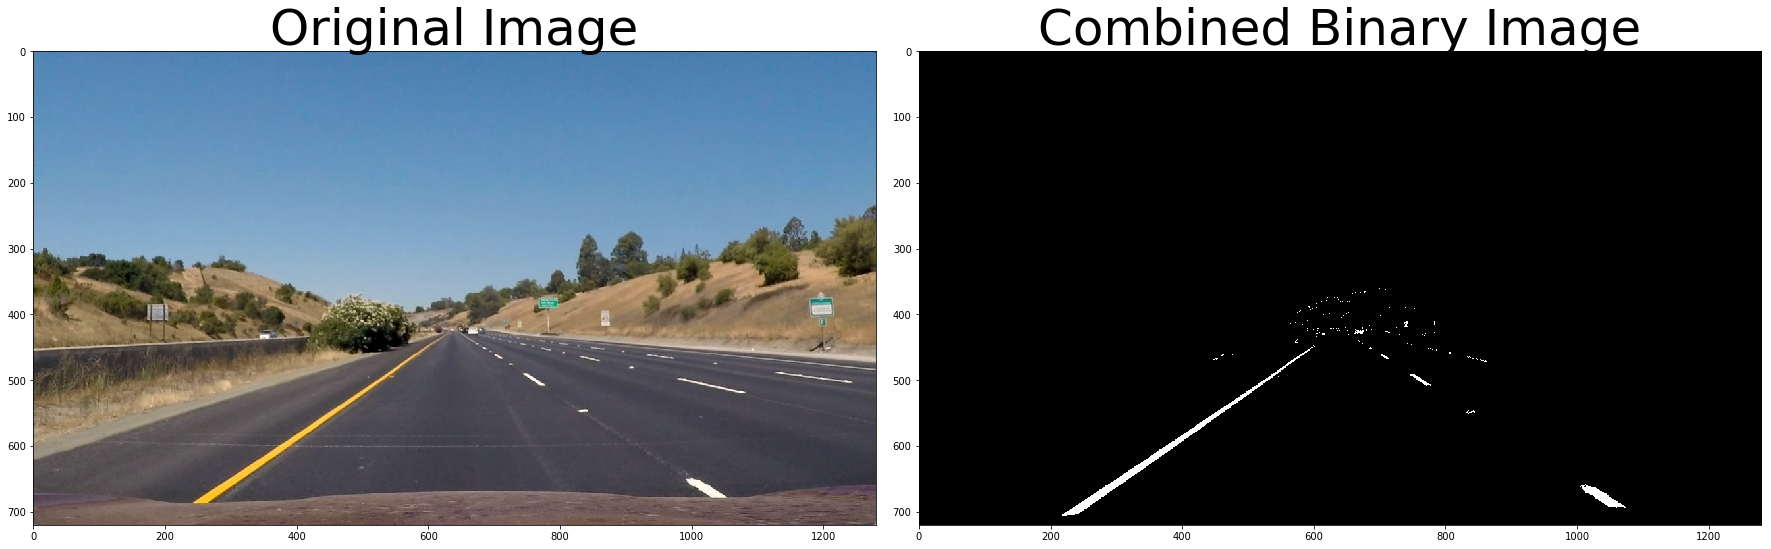

In [6]:
image = mpimg.imread("test_images/straight_lines1.jpg")

binary_output = get_thresholded_binary(image)
draw_images(image, binary_output, title="Combined Binary Image", cmap='gray', outputfig='output_images/thresholded_binary.png')

## Perspective Transform

I select source points mannually. The dst points should be keep line as straight. Is there a good way to find source points? I just try them again and again.

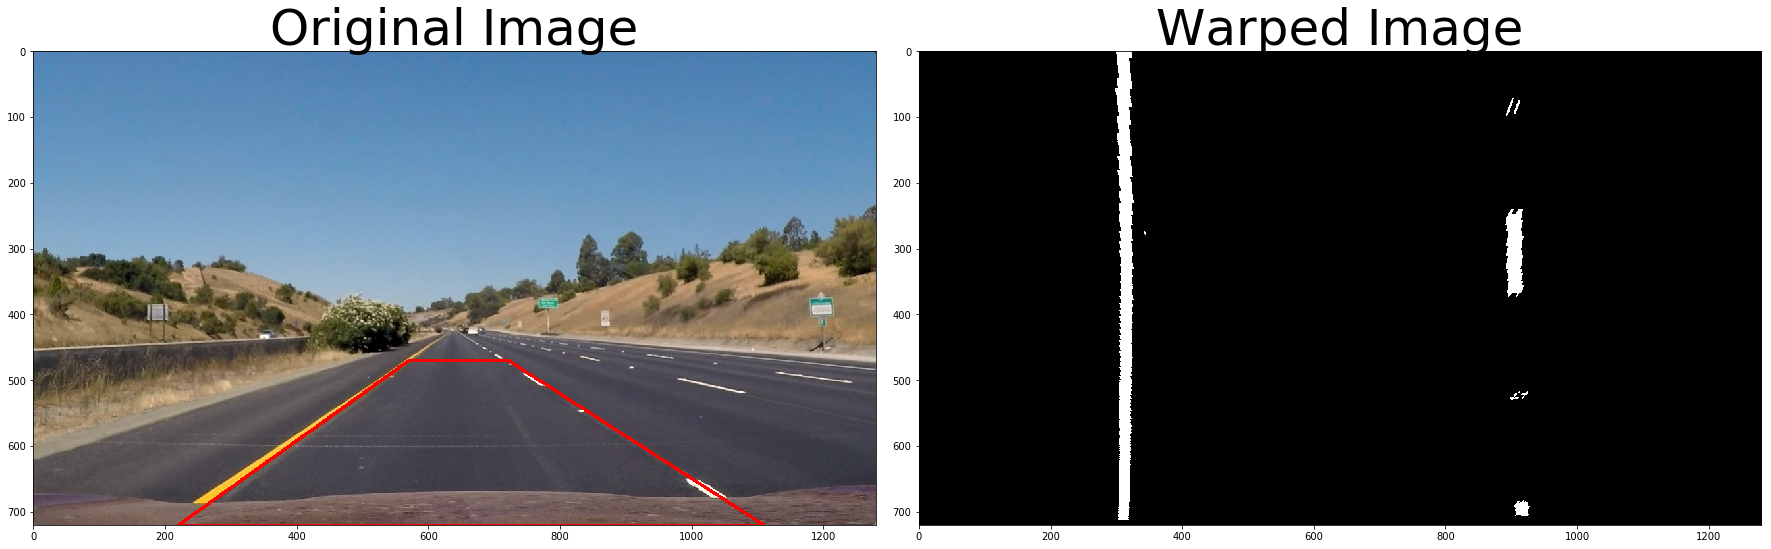

In [7]:
def unwarp_image(image, src_points, dst_points):
    img_size = (image.shape[1], image.shape[0])
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    p_img = cv2.warpPerspective(image, M, dsize=img_size)
    return p_img

# Mannually select src points and dst points
bottom_left = [220,720]
bottom_right = [1110, 720]
top_left = [570, 470]
top_right = [722, 470]

src_points = np.float32([bottom_left,bottom_right,top_right,top_left])

pts = np.array([bottom_left,bottom_right,top_right,top_left], np.int32)
pts = pts.reshape((-1,1,2))
copy = image.copy()
cv2.polylines(copy,[pts],True,(255,0,0), thickness=3)

bottom_left = [320,720]
bottom_right = [920, 720]
#bottom_left = [220, 720]
#bottom_right = [1110, 720]

#top_left = [220, 1]
#top_right = [1110, 1]
top_left = [320, 1]
top_right = [920, 1]

dst_points = np.float32([bottom_left,bottom_right,top_right,top_left])

warped_image = unwarp_image(binary_output, src_points, dst_points)
draw_images(copy, warped_image, title='Warped Image', cmap='gray', outputfig='output_images/warped_image.png')

## Find Lane Line Pixels And Fit The Line

In the lesson, more than one method are introduced to find lane line. Let's see them through examples.

### Histogram

We can use histogram to find the left and right lane line base.

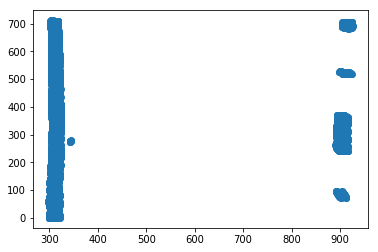

In [8]:
def histogram(img):
    img = img/255
    bottom_half = img[img.shape[0]//2:,:]
    h = np.sum(bottom_half, axis=0)
    return h

hist = histogram(warped_image)

left_base = np.argmax(hist[:hist.shape[0]//2])
right_base = np.argmax(hist[hist.shape[0]//2:]) + hist.shape[0]//2

nozero = np.nonzero(warped_image)
plt.scatter(nozero[1], nozero[0])
x = nozero[1]
y = nozero[0]

w = ((x>=100) & (x<=300) & (y>=300) & (y<=500)).nonzero()[0]
plt.scatter(x[w], y[w], color='red')

### Sliding Window Search

Through histogram, we can find the lane line base. Then find lane line pixels by sliding window. And polynomial fit is a good choice for curve fitting.

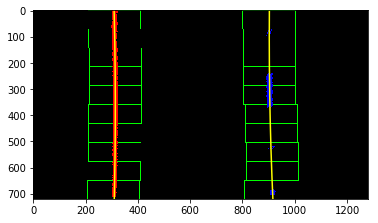

In [9]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 10
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 100

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2)  # left lane line window
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2)  # right lane line window
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy>=win_y_low) & (nonzeroy<win_y_high) & (nonzerox>=win_xleft_low) & (nonzerox<win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy>=win_y_low) & (nonzeroy<win_y_high) & (nonzerox>=win_xright_low) & (nonzerox<win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img

out_img = fit_polynomial(warped_image)

plt.imshow(out_img)
plt.savefig('output_images/warped_image_lane_lines.png')

## Determine the curvature of the lane and vehicle position with respect to center

In [10]:
"""meters per pixel in y dimension"""
YM_PER_PIX = 30/720
"""meters per pixel in x dimension"""
XM_PER_PIX = 3.7/700

def ploy_fit_prediction(ploty, ployfit):
    """
    Calcute x values based on ployfit function. The input is Y dimension.
    """
    return ployfit[0]*ploty**2 + ployfit[1]*ploty + ployfit[2]

def pixels_fit(y_values, x_values, pixel2meter=False):
    """
    Fit new polynomials to x,y
    """
    yfactor = 1 if not pixel2meter else YM_PER_PIX
    xfactor = 1 if not pixel2meter else XM_PER_PIX
    fit = np.polyfit(y_values*yfactor, x_values*xfactor, 2)
    return fit

def measure_curvature_pixels(ploty, plotyfit):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    # Implement the calculation of R_curve (radius of curvature)
    line_curverad = ((1 + (2*plotyfit[0]*np.max(ploty) + plotyfit[1])**2)**1.5) / np.absolute(2*plotyfit[0])
    
    return line_curverad

leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped_image)

left_fit = pixels_fit(lefty, leftx)
right_fit = pixels_fit(righty, rightx)

ploty = np.linspace(0, warped_image.shape[0]-1, warped_image.shape[0])

"""prediction left lane line x"""
h_l_x = ploy_fit_prediction(ploty, ployfit=left_fit)
"""prediction right lane line x"""
h_r_x = ploy_fit_prediction(ploty, ployfit=right_fit)

left_curve_r = measure_curvature_pixels(ploty, pixels_fit(ploty, h_l_x, pixel2meter=True))
right_curve_r = measure_curvature_pixels(ploty, pixels_fit(ploty, h_r_x, pixel2meter=True))

avg_curve_radius = (left_curve_r + right_curve_r)/2 
print("Radius of curvature: %.2f m" % avg_curve_radius)

Radius of curvature: 4809.06 m


## Warp the detected lane boundaries back onto the original image

We have got a warp image and two detected lane boudaries. Now, We need to warp back onto the original image.

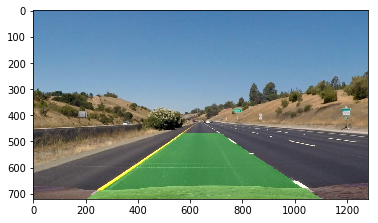

In [11]:

out_img = np.dstack((warped_image, warped_image, warped_image))*255
y_points = np.linspace(0, warped_image.shape[0]-1, warped_image.shape[0])
left_line_window = np.array(np.transpose(np.vstack([h_l_x, ploty])))
right_line_window = np.array(np.flipud(np.transpose(np.vstack([h_r_x, ploty]))))
line_points = np.vstack((left_line_window, right_line_window))
cv2.fillPoly(out_img, np.int_([line_points]), [0,255, 0])
M_inv = cv2.getPerspectiveTransform(dst_points, src_points)
img_size = (image.shape[1], image.shape[0])
unwarped = cv2.warpPerspective(out_img, M_inv, img_size, flags=cv2.INTER_LINEAR)
result = cv2.addWeighted(image, 1, unwarped, 0.3, 0)
plt.imshow(result)
plt.savefig('output_images/unwarp_boundaries.png')

## Final Pipeline

In [17]:
def lane_line_pipeline(image):
    # 1) Get thresholded binary image
    thresholded_binary = get_thresholded_binary(image)
    # 2) Get Perspective view image
    
    def get_warp_matrix():
        """Mannually select src points and dst points"""
        bottom_left = [220,720]
        bottom_right = [1110, 720]
        top_left = [570, 470]
        top_right = [722, 470]

        src_points = np.float32([bottom_left,bottom_right,top_right,top_left])

        pts = np.array([bottom_left,bottom_right,top_right,top_left], np.int32)
        pts = pts.reshape((-1,1,2))

        bottom_left = [320,720]
        bottom_right = [920, 720]
        top_left = [320, 1]
        top_right = [920, 1]

        dst_points = np.float32([bottom_left,bottom_right,top_right,top_left])
        
        """get perspective transform matrix and inverse transform matrix"""
        M = cv2.getPerspectiveTransform(src_points, dst_points)
        M_inv = cv2.getPerspectiveTransform(dst_points, src_points)
        return M, M_inv
    
    """perspective transform matrix and inverse matrix"""
    M, M_inv = get_warp_matrix()
    
    """image size"""
    img_size = (image.shape[1], image.shape[0])
    
    warped_img = cv2.warpPerspective(thresholded_binary, M, dsize=img_size)
    
    # 3) Find lane line pixels
    """find lane line pixels through sliding window search"""
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped_img)
    
    if len(leftx) == 0 or len(rightx) == 0:
        return image  # bad line
    left_fit = pixels_fit(lefty, leftx)
    right_fit = pixels_fit(righty, rightx)

    ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0])

    """prediction left lane line x"""
    h_l_x = ploy_fit_prediction(ploty, ployfit=left_fit)
    """prediction right lane line x"""
    h_r_x = ploy_fit_prediction(ploty, ployfit=right_fit)

    # 4) Determine the curvature of the lane
    left_curve_r = measure_curvature_pixels(ploty, pixels_fit(ploty, h_l_x, pixel2meter=True))
    right_curve_r = measure_curvature_pixels(ploty, pixels_fit(ploty, h_r_x, pixel2meter=True))
    """average curve radius"""
    avg_curve_radius = (left_curve_r + right_curve_r)/2 
    avg_curve_radius_text = "Radius of curvature: %.2f m" % avg_curve_radius
    
    """compute the offset from the center"""
    lane_center = (h_r_x[img_size[1]-1] + h_l_x[img_size[1]-1])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_offset_pixels = abs(img_size[0]/2 - lane_center)
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    center_offset_text = "Center offset: %.2f m" % center_offset_mtrs
    
    # 5) Warp the detected lane boundaries back onto the original image
    out_img = np.dstack((warped_img, warped_img, warped_img))*255
    y_points = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0])
    left_line_window = np.array(np.transpose(np.vstack([h_l_x, ploty])))
    right_line_window = np.array(np.flipud(np.transpose(np.vstack([h_r_x, ploty]))))
    line_points = np.vstack((left_line_window, right_line_window))
    cv2.fillPoly(out_img, np.int_([line_points]), [0,255, 0])
    M_inv = cv2.getPerspectiveTransform(dst_points, src_points)
    img_size = (image.shape[1], image.shape[0])
    unwarped = cv2.warpPerspective(out_img, M_inv, img_size, flags=cv2.INTER_LINEAR)
    result = cv2.addWeighted(image, 1, unwarped, 0.3, 0)
    
    cv2.putText(result, avg_curve_radius_text , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    cv2.putText(result, center_offset_text, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    return result

## Test Image Output

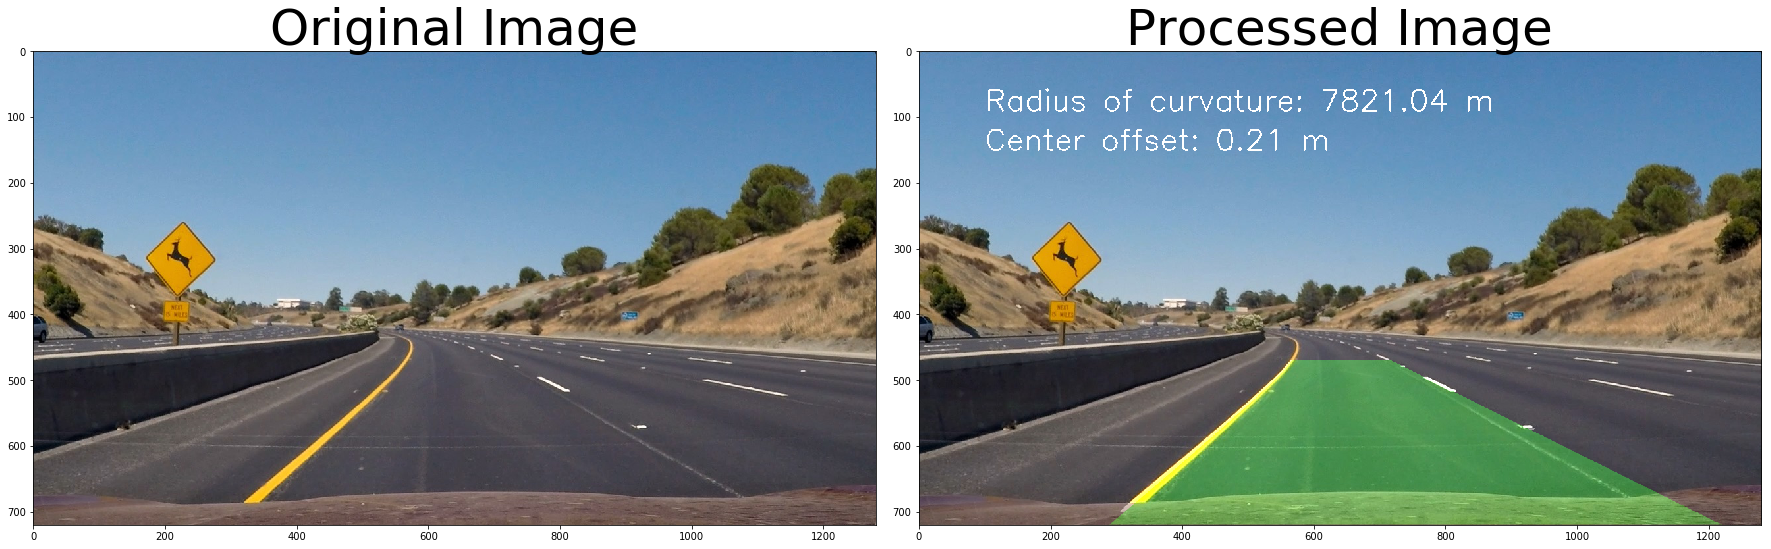

In [13]:
img = mpimg.imread('test_images/test2.jpg')

# Apply lane line pipeline
processed = lane_line_pipeline(img)

# Plot the 2 images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(processed, cmap='gray')
ax2.set_title('Processed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig("output_images/lane_line_pipeline.png")

## Test On Video

In [14]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(lane_line_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [05:02<00:00,  4.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 4min 24s, sys: 51.2 s, total: 5min 15s
Wall time: 5min 5s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [23]:
challenge_video_output = 'challenge_video_output.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(lane_line_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(challenge_video_output, audio=False)

In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_video_output))